In [26]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import ta

In [2]:
# Existing code for data fetching
ticker = 'GME'
stockPrices = yf.download(ticker, '1981-01-01', '2024-07-20')

[*********************100%%**********************]  1 of 1 completed


In [3]:
stockPrices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-02-13,2.40625,2.51500,2.38125,2.51250,1.691667,76216000
2002-02-14,2.54375,2.54875,2.48125,2.50000,1.683250,11021600
2002-02-15,2.50000,2.50625,2.46250,2.48750,1.674834,8389600
2002-02-19,2.47500,2.47500,2.34375,2.38750,1.607504,7410400
2002-02-20,2.40000,2.46875,2.38125,2.46875,1.662210,6892800


In [4]:
stockPrices.isnull()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-02-13,False,False,False,False,False,False
2002-02-14,False,False,False,False,False,False
2002-02-15,False,False,False,False,False,False
2002-02-19,False,False,False,False,False,False
2002-02-20,False,False,False,False,False,False
...,...,...,...,...,...,...
2024-07-15,False,False,False,False,False,False
2024-07-16,False,False,False,False,False,False
2024-07-17,False,False,False,False,False,False


In [5]:
stockPrices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5646 entries, 2002-02-13 to 2024-07-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5646 non-null   float64
 1   High       5646 non-null   float64
 2   Low        5646 non-null   float64
 3   Close      5646 non-null   float64
 4   Adj Close  5646 non-null   float64
 5   Volume     5646 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 308.8 KB


In [6]:
stockPrices.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [7]:
stockPrices.shape

(5646, 6)

In [8]:
stockPrices.size

33876

In [9]:
stockPrices.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5646.000000,5646.000000,5646.000000,5646.000000,5646.000000,5.646000e+03
mean,9.371573,9.688580,9.058711,9.352457,8.018803,1.453099e+07
std,10.389287,11.038386,9.748765,10.295986,10.540438,2.981795e+07
min,0.712500,0.735000,0.642500,0.700000,0.638794,2.600000e+05
25%,3.670625,3.745000,3.600625,3.675000,2.920049,5.394800e+06
50%,5.972500,6.055000,5.866250,5.971250,4.234187,9.626400e+06
75%,10.551875,10.743125,10.382500,10.567500,7.641419,1.518860e+07
max,94.927498,120.750000,72.877502,86.877502,86.877502,7.886316e+08


In [10]:
stockPrices.fillna(method='bfill', inplace=True)

C:\Users\Loricson\AppData\Local\Temp\ipykernel_48880\2759988.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stockPrices.fillna(method='bfill', inplace=True)


In [11]:
# Clean the column names
stockPrices.columns = stockPrices.columns.str.strip()

In [12]:
# Compute additional features
stockPrices['SMA_50'] = stockPrices['Close'].rolling(window=50).mean()
stockPrices['EMA_20'] = stockPrices['Close'].ewm(span=20, adjust=False).mean()
stockPrices['RSI'] = ta.momentum.rsi(stockPrices['Close'], window=14)
stockPrices['MACD'] = ta.trend.macd(stockPrices['Close'])
stockPrices['Bollinger_High'] = ta.volatility.bollinger_hband(stockPrices['Close'])
stockPrices['Bollinger_Low'] = ta.volatility.bollinger_lband(stockPrices['Close'])
stockPrices['ATR'] = ta.volatility.average_true_range(stockPrices['High'], stockPrices['Low'], stockPrices['Close'])
stockPrices['Stochastic'] = ta.momentum.stoch(stockPrices['High'], stockPrices['Low'], stockPrices['Close'])
stockPrices['OBV'] = ta.volume.on_balance_volume(stockPrices['Close'], stockPrices['Volume'])

In [13]:
# Drop the 'Date' column if it is still present
stockPrices.reset_index(drop=True, inplace=True)

In [14]:
# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stockPrices[['Close', 'SMA_50', 'EMA_20', 'RSI', 'MACD', 'Bollinger_High', 'Bollinger_Low', 'ATR', 'Stochastic', 'OBV']])

In [15]:
# Prepare the data for LSTM
def prepare_lstm_data(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(data[i, 0])  # Close price as the target
    return np.array(X), np.array(y)

In [16]:
# Hyperparameters
time_steps = 60

In [17]:
# Prepare the LSTM data
X_lstm, y_lstm = prepare_lstm_data(scaled_data, time_steps)

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, shuffle=False)


In [19]:
# Reshape the data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [20]:
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Compile model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [22]:
# Train model
history = lstm_model.fit(X_train, y_train, epochs=80, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: nan - val_loss: nan
Epoch 2/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: nan - val_loss: nan
Epoch 3/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: nan - val_loss: nan
Epoch 4/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: nan - val_loss: nan
Epoch 5/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: nan - val_loss: nan
Epoch 6/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: nan - val_loss: nan
Epoch 7/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: nan - val_loss: nan
Epoch 8/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: nan - val_loss: nan
Epoch 9/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: nan - val_loss: nan
Epoch 10/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: nan - val_loss: nan
Epoch 11/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: nan - val_loss: nan
Epoch 12/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: nan - val_loss: nan
Epoch 13/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/st

In [23]:
# Predict and invert scaling
predicted_prices = lstm_model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.concatenate([predicted_prices, np.zeros((predicted_prices.shape[0], scaled_data.shape[1] - 1))], axis=1))[:,0]

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [28]:
# Calculate MSE for LSTM model
mse_lstm = mean_squared_error(stockPrices['Close'][-len(predicted_prices):], predicted_prices)
print(f'LSTM Model Mean Squared Error: {mse_lstm:.4f}')

ValueError: Input contains NaN.

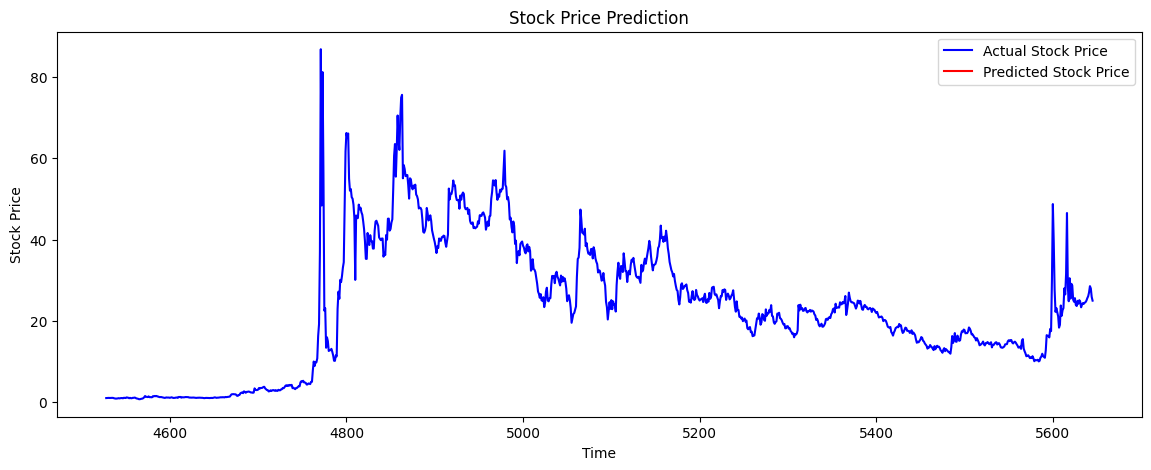

In [29]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(stockPrices.index[-len(predicted_prices):], stockPrices['Close'][-len(predicted_prices):], color='blue', label='Actual Stock Price')
plt.plot(stockPrices.index[-len(predicted_prices):], predicted_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Manipulation Model

In [30]:
# Example feature engineering for manipulation detection
stockPrices['Spread'] = stockPrices['High'] - stockPrices['Low']
stockPrices['Volatility'] = stockPrices['Close'].rolling(window=10).std()
stockPrices['Trade_Ratio'] = stockPrices['Volume'] / stockPrices['Volume'].rolling(window=10).mean()

In [31]:
# Feature scaling
features = ['Close', 'SMA_50', 'EMA_20', 'RSI', 'MACD', 'Bollinger_High', 'Bollinger_Low', 'ATR', 'Stochastic', 'OBV', 'Spread', 'Volatility', 'Trade_Ratio']
scaler_fnn = MinMaxScaler()
scaled_data_fnn = scaler_fnn.fit_transform(stockPrices[features])

In [32]:
# Build the Autoencoder model
input_dim = scaled_data_fnn.shape[1]
encoding_dim = 14

In [33]:
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(encoding_dim // 2, activation="relu")(encoder)
decoder = Dense(encoding_dim // 2, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [34]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [35]:
autoencoder.fit(scaled_data_fnn, scaled_data_fnn, epochs=100, batch_size=128, validation_split=0.1)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: nan - val_loss: 0.1725
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - val_loss: 0.1725
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - val_loss: 0.1725
Epoch 13/100


In [36]:
# Use the Autoencoder to predict and calculate reconstruction error
predicted_data = autoencoder.predict(scaled_data_fnn)
mse = np.mean(np.power(scaled_data_fnn - predicted_data, 2), axis=1)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


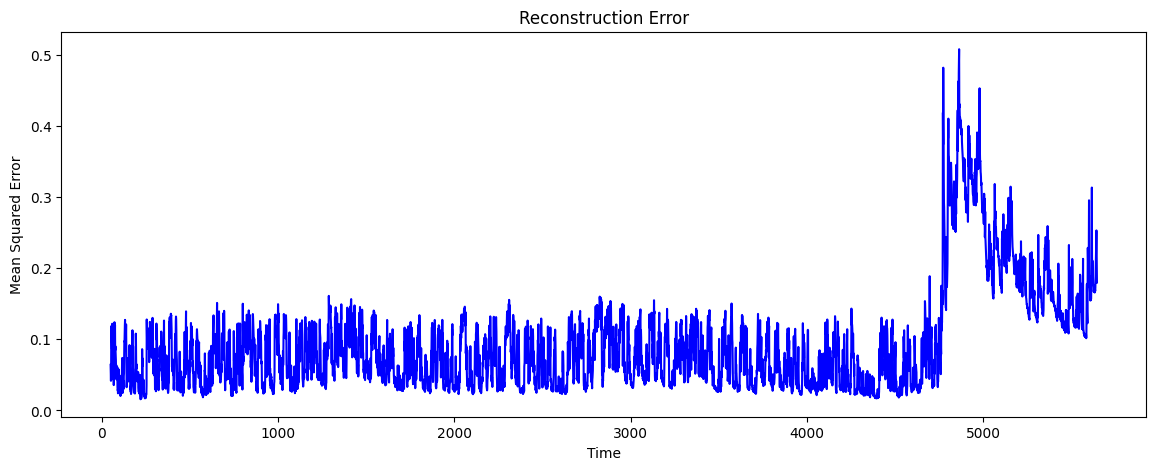

In [37]:
# Plot the reconstruction error
plt.figure(figsize=(14, 5))
plt.plot(mse, color='blue')
plt.title('Reconstruction Error')
plt.xlabel('Time')
plt.ylabel('Mean Squared Error')
plt.show()

In [38]:
# Define a threshold for anomaly detection
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

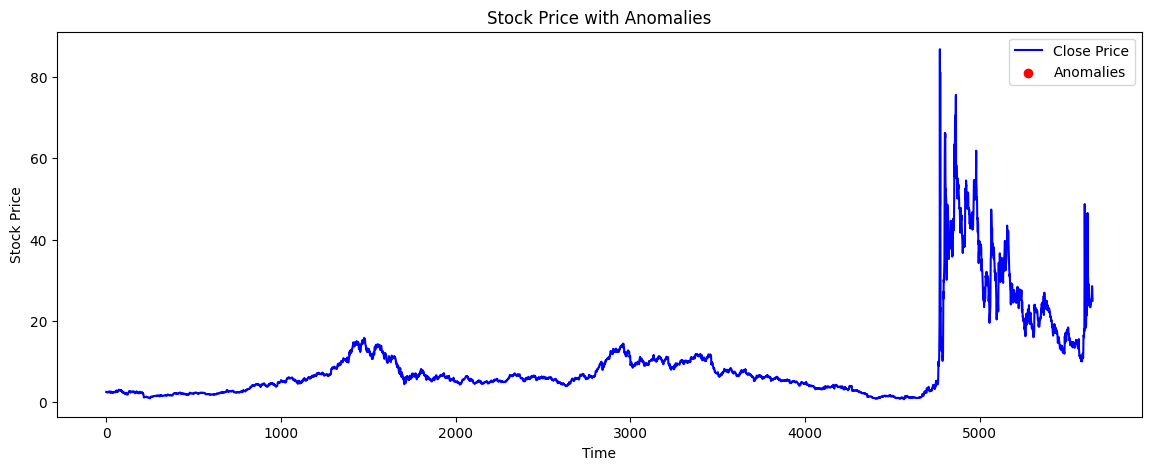

In [39]:
# Plot the anomalies on the original data
plt.figure(figsize=(14, 5))
plt.plot(stockPrices.index, stockPrices['Close'], color='blue', label='Close Price')
plt.scatter(stockPrices.index[anomalies], stockPrices['Close'][anomalies], color='red', label='Anomalies')
plt.title('Stock Price with Anomalies')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()